In [46]:
# Pip imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import stan

try:
    import arviz as az
except ImportError as err:
    print("Please, install arviz for easy visualization of Stan models.")

import nest_asyncio
nest_asyncio.apply()

import pandas as pd

print(stan.__version__)

3.10.0


In [47]:
stan_code = """

data {
    int<lower=1> N; //Size of the training set
    int<lower=1> M; //Size of the test set
    matrix[N, 4] x_train;
    matrix[M, 4] x_test;
    vector[N] y;
}

parameters {
    real<lower=0> sigma;
    real alpha;
    vector[4] beta;
}

model {
    sigma ~ inv_gamma(50, 100);
    alpha ~ normal(0, 2);
    beta ~ normal(0, 2);
    

    y ~ normal(alpha + beta' * x_train', sigma);
    //for (n in 1:N) {
    //    y[n] ~ normal(alpha + beta' * (x_train[n]'), sigma);
    //}
}

generated quantities{
  array[N] real gen_distr;
  array[M] real pred_distr;
  for(i in 1:N){
    gen_distr[i] = normal_rng(alpha + beta' * (x_train[i]'), sigma);
  }

  for(i in 1:M){
    pred_distr[i] = normal_rng(alpha + beta' * (x_test[i]'), sigma);
  }
}

"""

In [ ]:
# Read in the file
insurance_data = pd.read_csv("insurance.csv")

insurance_data = insurance_data.sample(frac=1).reset_index(drop=True)


insurance_data['smoker'] = insurance_data['smoker'] == 'yes'

key_param_df = insurance_data[['age', 'bmi', 'children', 'smoker']].astype(np.float64)

parameter_vals = key_param_df.values
charges_vals = insurance_data['charges'].astype(np.float64).values

num_rows = parameter_vals.shape[0]

#Split data
split_proportion = 0.3
split_row = int(num_rows * (1-split_proportion))

training_data_params = parameter_vals[:split_row, :]
testing_data_params = parameter_vals[split_row:, :]

training_data_charges = charges_vals[:split_row]
testing_data_charges = charges_vals[split_row:]

#Normalize data
training_data_params = (training_data_params - np.mean(training_data_params, axis=0)) / np.std(training_data_params, axis=0)
testing_data_params = (testing_data_params - np.mean(testing_data_params, axis=0)) / np.std(testing_data_params, axis=0)

training_data_charges = (training_data_charges - np.mean(training_data_charges)) / np.std(training_data_charges)
testing_data_charges = (testing_data_charges - np.mean(testing_data_charges)) / np.std(testing_data_charges)

#Verify shapes
print(f"Shape of Total Data Set: {charges_vals.shape}")
print(f"Split Row: {split_row}")
print(f"Shape of Training Set: {training_data_charges.shape}")
print(f"Shape of Test Set: {testing_data_charges.shape}")

[[ 1.2935422  -0.77727696  0.76356373 -0.51796977]
 [-1.3545605  -0.52178505 -0.92203922  1.9306146 ]
 [-0.06629432 -0.40714124  1.6063652  -0.51796977]
 ...
 [-0.06629432 -1.72554501 -0.07923775 -0.51796977]
 [ 1.65139391  0.25042288 -0.92203922  1.9306146 ]
 [-1.06827913  1.58274768 -0.92203922  1.9306146 ]]
Shape of Total Data Set: (1338,)
Split Row: 936
Shape of Training Set: (936,)
Shape of Test Set: (402,)


In [49]:

data_dict = { 
    'N': training_data_charges.shape[0],
    'M': testing_data_charges.shape[0],
    'x_train': training_data_params,
    'x_test': testing_data_params,
    'y': training_data_charges
}

model = stan.build(stan_code, data=data_dict)

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_8cjo1c_9/model_gp3aexhc.stan', line 18, column 26: Argument
    100 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_8cjo1c_9/model_gp3aexhc.stan', line 18, column 22: Argument
    50 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).


In [50]:
fit = model.sample(num_chains=4, num_samples=10000, num_warmup=1000)

Sampling:   0%
Sampling:  25% (11000/44000)
Sampling:  50% (22000/44000)
Sampling:  75% (33000/44000)
Sampling: 100% (44000/44000)
Sampling: 100% (44000/44000), done.
Messages received during sampling:
  Gradient evaluation took 0.000136 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.36 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/httpstan_dwrnnak8/model_gp3aexhc.stan', line 23, column 4 to column 48)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Excepti

In [51]:
az.summary(fit, var_names=['sigma', 'alpha', 'beta'], filter_vars="like")

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,0.534,0.013,0.511,0.559,0.0,0.0,53638.0,31391.0,1.0
alpha,-0.000,0.017,-0.033,0.032,0.0,0.0,55286.0,32083.0,1.0
beta[0],0.299,0.018,0.266,0.332,0.0,0.0,54036.0,30984.0,1.0
beta[1],0.175,0.018,0.141,0.207,0.0,0.0,53895.0,32251.0,1.0
beta[2],0.057,0.018,0.025,0.091,0.0,0.0,52505.0,31876.0,1.0
beta[3],0.798,0.017,0.765,0.830,0.0,0.0,52716.0,31391.0,1.0


array([[<Axes: title={'center': 'beta\n0'}>,
        <Axes: title={'center': 'beta\n0'}>],
       [<Axes: title={'center': 'beta\n1'}>,
        <Axes: title={'center': 'beta\n1'}>],
       [<Axes: title={'center': 'beta\n2'}>,
        <Axes: title={'center': 'beta\n2'}>],
       [<Axes: title={'center': 'beta\n3'}>,
        <Axes: title={'center': 'beta\n3'}>]], dtype=object)

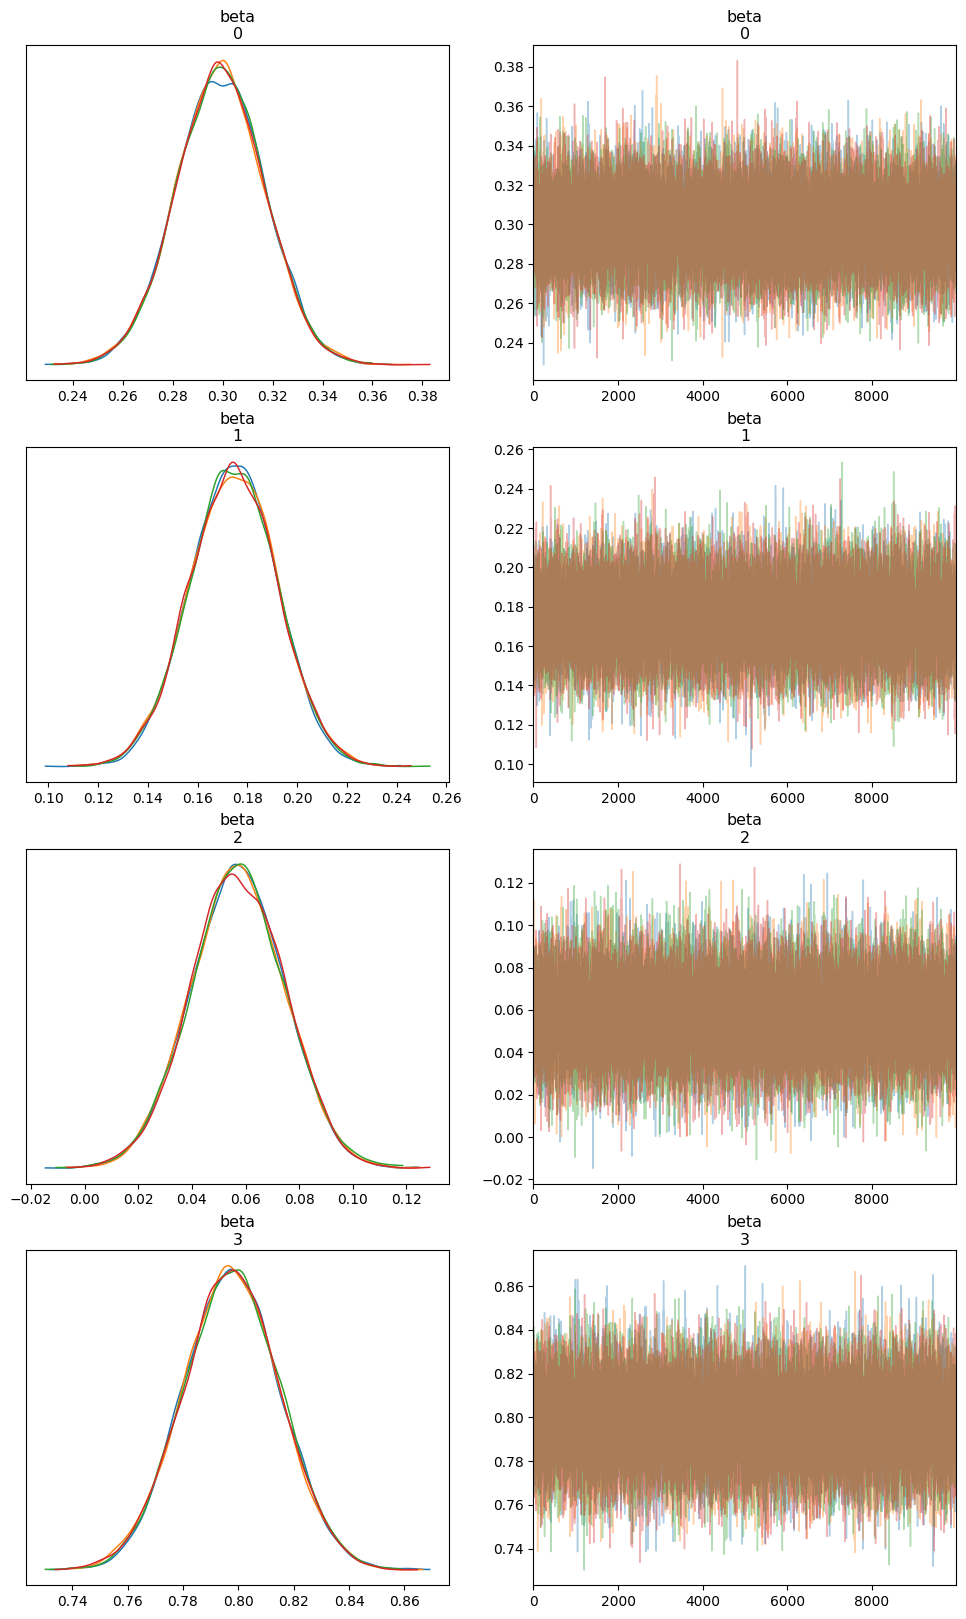

In [52]:
# Plot anything all beta values
columns_to_plot_trace_of = ['beta']

az.plot_trace(fit, var_names=columns_to_plot_trace_of, filter_vars='like', compact=False, figsize=(12, 20))

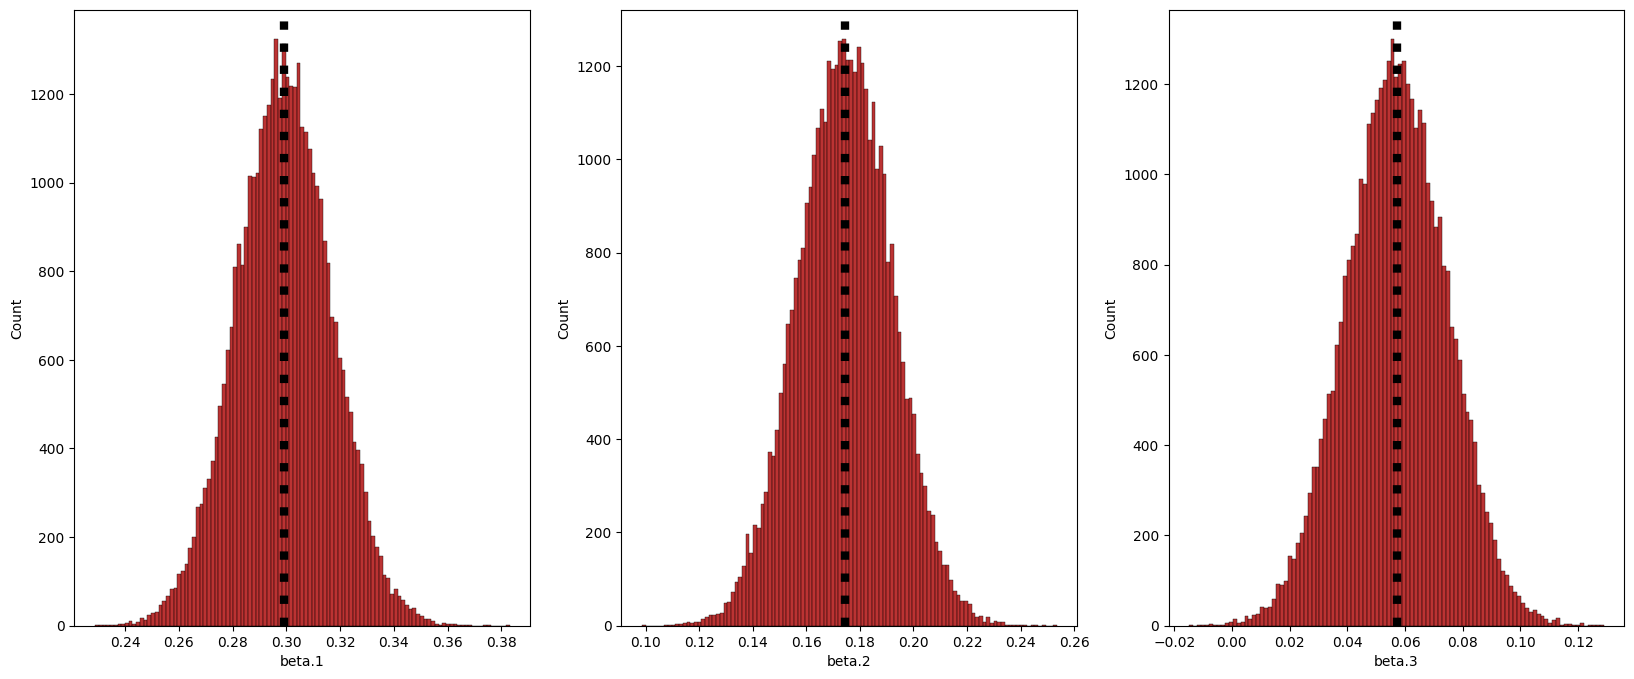

In [53]:
results_frame = fit.to_frame()

f, ax = plt.subplots(1, 3, figsize=(20, 8))

sns.histplot(results_frame, x='beta.1', ax = ax[0], color='#AA0000', alpha=0.8, lw=2)
sns.histplot(results_frame, x='beta.2', ax = ax[1], color='#AA0000', alpha=0.8, lw=2)
sns.histplot(results_frame, x='beta.3', ax = ax[2], color='#AA0000', alpha=0.8, lw=2)

ax[0].axvline(np.mean(results_frame['beta.1']), color='black', linestyle='dotted', lw=6)
ax[1].axvline(np.mean(results_frame['beta.2']), color='black', linestyle='dotted', lw=6)
ax[2].axvline(np.mean(results_frame['beta.3']), color='black', linestyle='dotted', lw=6)

### Problem 4

In [54]:
gen_distr = fit['gen_distr'] #Generative distribution (Training Set)
pred_distr = fit['pred_distr'] #Predictive distribution (Test Set)

gen_means = np.mean(gen_distr, axis=1) #Generative distribution means
pred_means = np.mean(pred_distr, axis=1) #Predictive distribution means

In [55]:
#Calculate the RMSE

train_rmse = np.sqrt(np.mean((gen_means - training_data_charges)**2))
test_rmse = np.sqrt(np.mean((pred_means - testing_data_charges)**2))

print(f"Training RMSE = {train_rmse}")
print(f"Test RMSE = {test_rmse}")



Training RMSE = 0.4917987797221921
Test RMSE = 0.5136680426876684
